# 10-703: Homework 1 - Behavior Cloning, DAGGER, CMA-ES, and GAIL

You will implement this assignment right here in this Colab notebook. Colab is a Jupyter notebook that runs in the cloud. If you haven't used Colab before, we recommend checking out the following tutorial:
https://colab.sandbox.google.com/notebooks/welcome.ipynb.
Note that all cells modify the same global state, so imported packages as well as functions and variables declared in one cell will be accessible in other cells.


To get started, click the ``Open in Playground`` button in the upper right. Then click the ``Copy to Drive`` button in the upper center to save a copy in your Google drive. In the future, you will be able to find the notebook by looking in your Google drive folder.

Now, you're ready start coding. You will want to run each cell in this notebook by clicking the "play" button to the left of the cell (or using [ctrl -> enter]. Look for ``WRITE CODE HERE'' to identify places where you need to write some code. Each section involves writing 3 - 10 lines of code. 

When you're done, copy plots genetated by your code into the solution boxes in the submission LaTeX file released with this assignment. In addition to uploading your PDF submission to GradeScope (one per group), you should also upload your code. To do this, explort the code from this notebook (File -> Export.py), and then upload the .py file to GradeScope.


# Preliminaries
In these first few cells, you will implement some compoments that will be used for all problems.


### Setup: Import Dependencies

In [38]:
from collections import OrderedDict 
import gym
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt
import numpy as np 
import subprocess 
import random
import tensorflow as tf
from numpy.random import seed
from tensorflow import set_random_seed
import pdb

### Make the TF Model
We'll use the same architecture for each of the problems. By implementing a function that creates the model here, you won't need to implement it again for each problem.

In [39]:
def make_model(input_shape):
    model = Sequential()      
    # WRITE CODE HERE
    # Add layers to the model:  
    # a fully connected layer with 10 units
    # a tanh activation
    # another fully connected layer with 2 units (the number of actions)
    # a softmax activation (so the output is a proper distribution)

    model.add(Dense(10, input_dim=input_shape))
    model.add(Activation('tanh'))

    model.add(Dense(2, input_dim=10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                     optimizer=tf.train.AdamOptimizer(),
                     metrics=['accuracy'])

    # We expect the model to have four weight variables (a kernel and bias for
    # both layers)
    assert len(model.weights) == 4, 'Model should have 4 weights.'
    return model

### Test the model
To confirm that the model is correct, we'll use it to solve a binary classification problem. The target function $f: \mathbb{R}^4 \rightarrow {0, 1}$ indicates whether the sum of the vector coordinates is positive:
$$f(x) = \delta \left(\sum_{i=1}^4 x_i > 0 \right)$$

You should achieve an accuracy of at least 98%.

In [40]:
model = make_model(input_shape=4)
for t in range(20):
    X = np.random.normal(size=(1000, 4))  # some random data
    is_positive = np.sum(X, axis=1) > 0  # A simple binary function
    Y = np.zeros((1000, 2))
    Y[np.arange(1000), is_positive.astype(int)] = 1  # one-hot labels
    history = model.fit(X, Y, epochs=10, batch_size=256, verbose=0)
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    print('(%d) loss= %.3f; accuracy = %.1f%%' % (t, loss, 100 * acc))

(0) loss= 0.332; accuracy = 95.2%
(1) loss= 0.265; accuracy = 97.3%
(2) loss= 0.236; accuracy = 97.9%
(3) loss= 0.202; accuracy = 98.7%
(4) loss= 0.181; accuracy = 98.6%
(5) loss= 0.158; accuracy = 99.8%
(6) loss= 0.145; accuracy = 99.4%
(7) loss= 0.131; accuracy = 99.3%
(8) loss= 0.122; accuracy = 99.0%
(9) loss= 0.115; accuracy = 99.5%
(10) loss= 0.107; accuracy = 99.6%
(11) loss= 0.103; accuracy = 99.3%
(12) loss= 0.094; accuracy = 99.5%
(13) loss= 0.083; accuracy = 99.8%
(14) loss= 0.078; accuracy = 99.3%
(15) loss= 0.071; accuracy = 99.7%
(16) loss= 0.076; accuracy = 99.8%
(17) loss= 0.073; accuracy = 99.3%
(18) loss= 0.070; accuracy = 99.5%
(19) loss= 0.065; accuracy = 99.7%


### Interacting with the Gym
Implement the function below for gathering an episode (a "rollout"). The environment we will use will implement the OpenAI Gym interface. For documentation, please see the link below:
http://gym.openai.com/docs/#environments

In [42]:
def action_to_one_hot(env, action):
    action_vec = np.zeros(env.action_space.n)
    action_vec[action] = 1
    return action_vec    
  
def disc_action_to_one_hot(disc_classes, action):
    action_vec = np.zeros(disc_classes)
    action_vec[action] = 1
    return action_vec    
          
def generate_episode(env, policy):
    """Collects one rollout from the policy in an environment. The environment
    should implement the OpenAI Gym interface. A rollout ends when done=True. The
    number of states and actions should be the same, so you should not include
    the final state when done=True.

    Args:
    env: an OpenAI Gym environment.
    policy: a keras model
    Returns:
    states: a list of states visited by the agent.
    actions: a list of actions taken by the agent. While the original actions
      are discrete, it will be helpful to use a one-hot encoding. The actions
      that you return should be one-hot vectors (use action_to_one_hot())
    rewards: the reward received by the agent at each step.
    """
    done = False
    state = env.reset()

    states = []
    actions = []
    rewards = []
    while not done:
      # WRITE CODE HERE
        states.append(state)
        action = np.argmax(policy.predict(np.expand_dims(state,axis=0)))
        actions.append(action_to_one_hot(env, action))
        state, reward, done, info = env.step(action)
        rewards.append(reward)

    return np.array(states), np.array(actions), np.array(rewards)

### Test the data collection
Run the following cell and make sure you see "Test passed!"

In [43]:
# Create the environment.
env = gym.make('CartPole-v0')
policy = make_model(env.observation_space.shape[0])
states, actions, rewards = generate_episode(env, policy)
assert len(states) == len(actions), 'Number of states and actions should be equal.'
assert len(actions) == len(rewards), 'Number of actions and rewards should be equal.'
assert len(actions[0]) == 2, 'Actions should use one-hot encoding.'
print('Test passed!')

Test passed!


### Download the expert policy
Click on the link below to download the expert policy (`expert.h5`):
https://drive.google.com/uc?export=download&id=1n62yCdr_gfvvoWISpiz-RuM_TttxEjcq

In the left pane, navigate to the "Files" tab, and upload the `expert.h5` file. Run the cell below to confirm that the correct file has been uploaded.

In [16]:
!wget https://raw.githubusercontent.com/cmudeeprl/703website/master/assets/homework/hw1/expert.h5

--2019-09-19 14:36:04--  https://raw.githubusercontent.com/cmudeeprl/703website/master/assets/homework/hw1/expert.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44536 (43K) [application/octet-stream]
Saving to: ‘expert.h5’

expert.h5           100%[===================>]  43.49K  --.-KB/s    in 0.03s   

2019-09-19 14:36:04 (1.23 MB/s) - ‘expert.h5’ saved [44536/44536]



## Problem 1: Behavior Cloning and DAGGER (50 pt)

### Implementing Behavior Cloning and DAGGER
To implement behavior cloning and DAGGER, fill in the missing blocks of code below. The provided code loads an expert model upon creation of the `Imitation` class. The function `generate_behavior_cloning_data()` fills in `self._train_states` and `self._train_actions` with states and actions from a single episode. Later, when implementing DAGGER, you will finish implementing `generate_dagger_data()`.

In [44]:
class Imitation():

    def __init__(self, env, num_episodes):
        self.env = env
        self.expert = tf.keras.models.load_model('expert.h5')
        self.num_episodes = num_episodes
        
        
        self.model = make_model(self.env.observation_space.shape[0])
        
    def generate_behavior_cloning_data(self):
        self._train_states = []
        self._train_actions = []
        for _ in range(self.num_episodes):
            states, actions, rewards = generate_episode(self.env, self.expert)
            self._train_states.extend(states)
            self._train_actions.extend(actions)
        self._train_states = np.array(self._train_states)
        self._train_actions = np.array(self._train_actions)
        
    def generate_dagger_data(self):
        # WRITE CODE HERE
        # You should collect states and actions from the student policy
        # (self.model), and then relabel the actions using the expert policy.
        # This method does not return anything.
        self._train_states = []
        self._train_actions = []
        for _ in range(self.num_episodes):
            states, actions, rewards = generate_episode(self.env, self.model)
            self._train_states.extend(states)
            self._train_actions.extend(actions)
            
        for state_id,state in enumerate(self._train_states):
            self._train_actions[state_id] = action_to_one_hot(self.env,np.argmax(self.expert.predict(np.expand_dims(state,axis=0))))
          
        self._train_states = np.array(self._train_states)
        self._train_actions = np.array(self._train_actions)
        
    def train(self, num_epochs=200, render=False):
        """Trains the model on training data generated by the expert policy.
        Args:
          env: The environment to run the expert policy on.
          num_epochs: number of epochs to train on the data generated by the expert.
          render: Whether to render the environment.
        Return:
          loss: (float) final loss of the trained policy.
          acc: (float) final accuracy of the trained policy
        """
        # WRITE CODE HERE
        
        history = self.model.fit(self._train_states,self._train_actions, epochs=num_epochs) # batch_size=256, verbose=0
        loss = history.history['loss'][-1]
        acc = history.history['accuracy'][-1]
        return loss, acc


    def evaluate(self, policy, n_episodes=50):
        rewards = []
        for i in range(n_episodes):
            _, _, r = generate_episode(self.env, policy)
            rewards.append(sum(r))
        r_mean = np.mean(rewards)
        return r_mean

### Experiment: Student vs Expert
In the next two cells, you will compare the performance of the expert policy
to the imitation policies obtained via behavior cloning and DAGGER.

In [ ]:
# Uncomment one of the two lines below to select whether to run behavior
# cloning or dagger
mode = 'behavior cloning'
# mode = 'dagger'

num_episodes = 100  # Leave this fixed for now. You will experiment with
                    # changing it later.
num_iterations = 100  # Number of training iterations. Use a small number
                     # (e.g., 10) for debugging, and then try a larger number
                     # (e.g., 100).

# Create the environment.
env = gym.make('CartPole-v0')
im = Imitation(env, num_episodes)
expert_reward = im.evaluate(im.expert)
print('Expert reward: %.2f' % expert_reward)

loss_vec = []
acc_vec = []
imitation_reward_vec = []
for t in range(num_iterations):
    if mode == 'behavior cloning':
        im.generate_behavior_cloning_data()
    elif mode == 'dagger':
        im.generate_dagger_data()
    else:
        raise ValueError('Unknown mode: %s' % mode)
    loss, acc = im.train(num_epochs=1)
    imitation_reward = im.evaluate(im.model)
    loss_vec.append(loss)
    acc_vec.append(acc)
    imitation_reward_vec.append(imitation_reward)
    print('(%d) loss = %.3f; accuracy = %.2f; reward = %.1f' % (t, loss, acc, imitation_reward))

Expert reward: 200.00
Epoch 1/1
20000/20000 [==============================] - 0s 21us/step - loss: 0.4678 - accuracy: 0.7856
(0) loss = 0.468; accuracy = 0.79; reward = 83.2
Epoch 1/1
20000/20000 [==============================] - 0s 19us/step - loss: 0.3216 - accuracy: 0.8296
(1) loss = 0.322; accuracy = 0.83; reward = 157.5
Epoch 1/1
20000/20000 [==============================] - 0s 18us/step - loss: 0.2957 - accuracy: 0.8426
(2) loss = 0.296; accuracy = 0.84; reward = 179.9
Epoch 1/1
20000/20000 [==============================] - 0s 21us/step - loss: 0.2795 - accuracy: 0.8539
(3) loss = 0.279; accuracy = 0.85; reward = 192.3
Epoch 1/1
20000/20000 [==============================] - 0s 18us/step - loss: 0.2633 - accuracy: 0.8662
(4) loss = 0.263; accuracy = 0.87; reward = 200.0
Epoch 1/1
20000/20000 [==============================] - 0s 17us/step - loss: 0.2502 - accuracy: 0.8767
(5) loss = 0.250; accuracy = 0.88; reward = 200.0


### Plot the results
After saving your plots by running `plt.savefig(FILENAME)`, you can download them by navigating to the `Files` tab on the left, and then right-clicking on each filename and selecting `Download`.

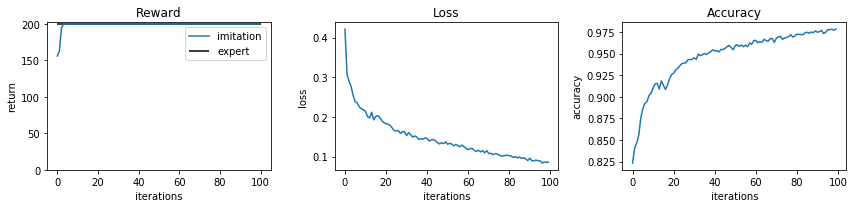

In [14]:
### Plot the results
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('Reward')
plt.plot(imitation_reward_vec, label='imitation')
plt.hlines(expert_reward, 0, len(imitation_reward_vec), label='expert')
plt.xlabel('iterations')
plt.ylabel('return')
plt.legend()
plt.ylim([0, None])

plt.subplot(132)
plt.title('Loss')
plt.plot(loss_vec)
plt.xlabel('iterations')
plt.ylabel('loss')

plt.subplot(133)
plt.title('Accuracy')
plt.plot(acc_vec)
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.tight_layout()
plt.savefig('student_vs_expert_%s.png' % mode, dpi=300)
plt.show()

### Experiment: How much expert data is needed?
This question studies how the amount of expert data effects the performance. You will run the same experiment as above, each time varying the number of expert episodes collected at each iteration. Use values of 1, 10, 50, and 100. You can keep the number of iterations fixed at 100.

In [9]:
random_seeds = 5
# Dictionary mapping number of expert trajectories to a list of rewards.
# Each is the result of running with a different random seed.
reward_data = OrderedDict({  
    1: [],
    10: [],
    50: [],
    100: []
})
accuracy_data = OrderedDict({  
    1: [],
    10: [],
    50: [],
    100: []
})
loss_data = OrderedDict({  
    1: [],
    10: [],
    50: [],
    100: []
})

mode = 'behavior cloning'
# mode = 'dagger'

for num_episodes in [1, 10, 50, 100]:#
  loss_vec = []
  acc_vec = []
  imitation_reward_vec = []
  for t in range(random_seeds):
    print('num_episodes: %s; seed: %d' % (num_episodes, t))
    
    # WRITE CODE HERE
    # Hint: The code here should be nearly identical to code after the
    # "Student vs Expert" cell. Feel free to copy and paste.
    seed(t)
    set_random_seed(t)
    env = gym.make('CartPole-v0')
    env.seed(t)

    
    num_iterations = 30  # Number of training iterations. Use a small number
                     # (e.g., 10) for debugging, and then try a larger number
                     # (e.g., 100).
    
    im = Imitation(env, num_episodes)
    loss_vec_seed =[]
    acc_vec_seed = []
    imitation_reward_vec_seed = []
    for i in range(num_iterations):
      if mode == 'behavior cloning':
        im.generate_behavior_cloning_data()
      elif mode == 'dagger':
        im.generate_dagger_data()
      else:
        raise ValueError('Unknown mode: %s' % mode)
        
      loss, acc = im.train(num_epochs=1)
      imitation_reward = im.evaluate(im.model)
      loss_vec_seed.append(loss)
      acc_vec_seed.append(acc)
      imitation_reward_vec_seed.append(imitation_reward)
      print('(%d) loss = %.3f; accuracy = %.2f; reward = %.1f' % (t, loss, acc, imitation_reward))
    loss_vec.append(loss_vec_seed)
    acc_vec.append(acc_vec_seed)
    imitation_reward_vec.append(imitation_reward_vec_seed)
    

  reward_data[num_episodes] = np.mean(np.array(imitation_reward_vec),axis=0)
  accuracy_data[num_episodes] = np.mean(np.array(acc_vec),axis=0)
  loss_data[num_episodes] = np.mean(np.array(loss_vec),axis=0)

num_episodes: 1; seed: 0
Epoch 1/1
200/200 [==============================] - 0s 1ms/step - loss: 0.6306 - acc: 0.7750
(0) loss = 0.631; accuracy = 0.78; reward = 69.3
Epoch 1/1
200/200 [==============================] - 0s 67us/step - loss: 0.6251 - acc: 0.8250
(0) loss = 0.625; accuracy = 0.82; reward = 66.2
Epoch 1/1
200/200 [==============================] - 0s 79us/step - loss: 0.6170 - acc: 0.7900
(0) loss = 0.617; accuracy = 0.79; reward = 66.4
Epoch 1/1
200/200 [==============================] - 0s 61us/step - loss: 0.6106 - acc: 0.7550
(0) loss = 0.611; accuracy = 0.76; reward = 69.4
Epoch 1/1
200/200 [==============================] - 0s 86us/step - loss: 0.6071 - acc: 0.8150
(0) loss = 0.607; accuracy = 0.81; reward = 63.2
Epoch 1/1
200/200 [==============================] - 0s 69us/step - loss: 0.5975 - acc: 0.7600
(0) loss = 0.598; accuracy = 0.76; reward = 64.4
Epoch 1/1
200/200 [==============================] - 0s 91us/step - loss: 0.5911 - acc: 0.8500
(0) loss = 0.591;

Plot the reward, loss, and accuracy for each, remembering to label each line.

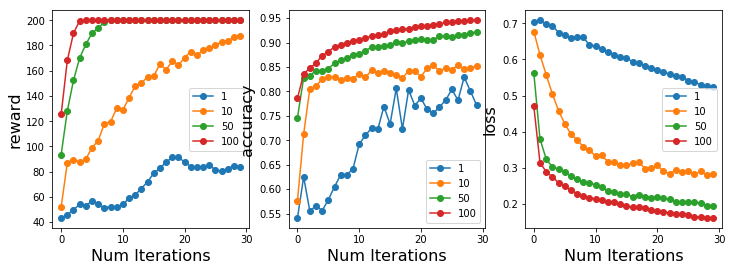

In [10]:
keys = [1, 10, 50, 100]
plt.figure(figsize=(12, 4))
# print(reward_data[1])
for (index, (data, name)) in enumerate(zip([reward_data, accuracy_data, loss_data],
                                           ['reward', 'accuracy', 'loss'])):

  plt.subplot(1, 3, index + 1)
#   plt.plot(data.keys(), data.values(), '-o')


  for key in data.keys():
    plt.plot(data[key], '-o')


  plt.xlabel('Num Iterations', fontsize=16)
  plt.ylabel(name, fontsize=16)
  plt.legend(['1','10','50','100'])
plt.savefig('expert_data_%s.png' % mode, dpi=300)
plt.show()

## Problem 2: CMA-ES (25 pt)
In this section, you will implement CMA-ES, a black-box optimization algorithm. You will then use CMA-ES to solve a reinforcement learning problem. In particular, the function you will maximize is
$$\max_\theta J(\theta) = E_{\pi_\theta} \left[ \sum_t r(s_t, a_t) \right]$$

In [ ]:
class CMAES:
    def __init__(self, env, L, n, p, sigma, noise, reward_fn=None):
        """
        Args:
          env: environment with which to evaluate different weights
          L: number of episodes used to evaluate a given set of weights
          n: number of members (weights) in each generation
          p: proportion of members used to update the mean and covariance
          sigma: initial std
          noise: additional noise to add to covariance
          reward_fn: if specified, this reward function is used instead of the 
            default environment reward. This will be used in Problem 3, when the
            reward function will come from the discriminator. The reward
            function should be a function of the state and action.
        """

        self.env = env
        self.model = make_model(self.env.observation_space.shape[0])
        # Let d be the dimension of the 1d vector of weights.
        self.d = sum(int(np.product(w.shape)) for w in self.model.weights)
        self.mu = np.zeros(self.d)
        self.S = sigma**2 * np.eye(self.d)

        self.L = L
        self.n = n
        self.p = p
        self.noise = noise
        self.reward_fn = reward_fn


    def populate(self):
        """
        Populate a generation using the current estimates of mu and S
        """
        self.population = []
        # WRITE CODE HERE
        self.population = np.random.multivariate_normal(self.mu,self.S,self.n)
        

    def set_weight(self, member):
        ind = 0
        weights = []
        for w in self.model.weights:
          if len(w.shape) > 1:
            mat = member[ind:ind+int(w.shape[0]*w.shape[1])]
            mat = np.reshape(mat, w.shape)
            ind += int(w.shape[0]*w.shape[1])
          else:
            mat = member[ind:ind+int(w.shape[0])]
            ind += int(w.shape[0])
          weights.append(mat)

        self.model.set_weights(weights)
        

    def evaluate(self, member, num_episodes):
        """
        Evaluate a set of weights by interacting with the environment and
        return the average total reward over num_episodes.
        """
        self.set_weight(member)
        return self.evaluate_policy(self.model, num_episodes)
    
    def evaluate_policy(self, policy, num_episodes):
        episode_rewards = []
        # WRITE CODE HERE
        for episode in range(num_episodes):
          states, actions, rewards = generate_episode(self.env, policy)
          if(self.reward_fn):
            rewards = np.array([self.reward_fn(s,0) for s in states])
          episode_rewards.append(np.sum(rewards))
          
        return np.mean(episode_rewards)

    def train(self):
        """
        Perform an iteration of CMA-ES by evaluating all members of the
        current population and then updating mu and S with the top self.p
        proportion of members. Note that self.populate automatically deletes
        all the old members, so you don't need to worry about deleting the
        "bad" members.

        """
        self.populate()
        #WRITE CODE HERE

        best_member = []
        rewards = []

        for member in self.population:
          r = self.evaluate(member,self.L) # L = num episodes
          rewards.append(r)
          
        top_ids = np.argsort(rewards)[-int(self.p*self.n):]

        self.mu = np.mean(self.population[top_ids],axis=0)

        self.S = np.cov(self.population[top_ids].T) + self.noise*np.eye(self.d)
        best_member = self.population[top_ids[-1]]
        best_r = self.evaluate(best_member, 10)
        mu_r   = self.evaluate(self.mu, 10)
        
        return mu_r, best_r



In [ ]:
iterations = 200  # Use 10 for debugging, and then try 200 once you've got it working.
pop_size_vec = [50]             # Start with a population size of 50. Once that
# pop_size_vec = [20, 50, 100]  # works, try varying the population size.
                              
data = {pop_size: [] for pop_size in pop_size_vec}

for pop_size in pop_size_vec:
  print('Population size:', pop_size)
  env = gym.make('CartPole-v0')
  optimizer = CMAES(env,
                    L=1,  # number of episodes for evaluation
                    n=pop_size,  # population size
                    p=0.25,  # proportion of population to keep
                    sigma=10,  # initial std dev
                    noise=0.25)  # noise

  for t in range(iterations):
      mu_r, best_r = optimizer.train()
      data[pop_size].append((mu_r, best_r))
      print('(%d) avg member rew = %.2f; best member rew = %.2f' % (t, mu_r, best_r))

Population size: 50
(0) avg member rew = 11.50; best member rew = 31.40
(1) avg member rew = 9.70; best member rew = 148.40
(2) avg member rew = 10.30; best member rew = 105.90
(3) avg member rew = 21.10; best member rew = 161.00
(4) avg member rew = 17.20; best member rew = 188.20
(5) avg member rew = 133.10; best member rew = 171.70
(6) avg member rew = 160.70; best member rew = 174.00
(7) avg member rew = 164.40; best member rew = 163.50
(8) avg member rew = 143.60; best member rew = 159.40
(9) avg member rew = 150.60; best member rew = 173.20
(10) avg member rew = 149.70; best member rew = 163.10
(11) avg member rew = 156.90; best member rew = 182.30


In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)  # Left plot will show performance vs number of iterations
for pop_size, values in data.items():
  mu_r = np.array(values)[:, 0]  # Use the performance of the best point
  best_r = np.array(values)[:, 1]
  x = np.arange(len(mu_r)) + 1
  plt.plot(x, mu_r, label=str(pop_size))
  plt.plot(x, best_r, label=str(pop_size))
  
  plt.ylabel('return', fontsize=16)
  plt.xlabel('num. iterations', fontsize=16)
  plt.legend(["mu_r","best_r"])


plt.tight_layout()
plt.savefig('cmaes_pop_size_1.png')
plt.show()

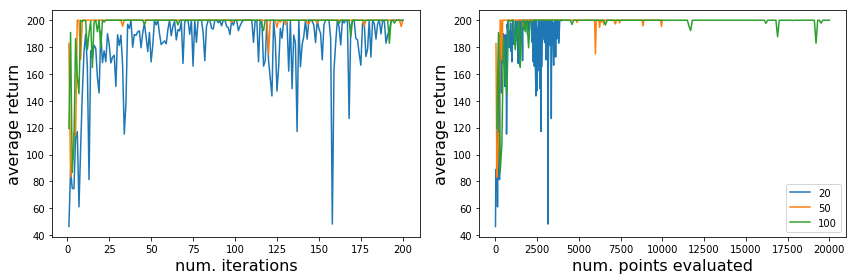

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)  # Left plot will show performance vs number of iterations
for pop_size, values in data.items():
  best_r = np.array(values)[:, 1]  # Use the performance of the best point
  x = np.arange(len(best_r)) + 1
  plt.plot(x, best_r, label=str(pop_size))
  plt.ylabel('Best return', fontsize=16)
  plt.xlabel('num. iterations', fontsize=16)

plt.subplot(122)  # Right plot will show performance vs number of points evaluated
for pop_size, values in data.items():
  best_r = np.array(values)[:, 1]  # Use the performance of the best point
  x = pop_size * (np.arange(len(best_r)) + 1)
  plt.plot(x, best_r, label=str(pop_size))
  plt.ylabel('Best return', fontsize=16)
  plt.xlabel('num. points evaluated', fontsize=16)

plt.legend()
plt.tight_layout()
plt.savefig('cmaes_pop_size.png')
plt.show()

## Problem 3: GAIL (25 pt)
For this problem, we will only condition the discriminator on the state, not the action.

In [ ]:
class GAIL(object):
  
  def __init__(self, env):
    self.env = env
    self.expert = tf.keras.models.load_model('expert.h5')
#     self.model = make_model()
    self.discriminator = make_model(self.env.observation_space.shape[0])
    print("init",self._reward_fn)
    self.cmaes = CMAES(env,
                  L=1,  # number of episodes for evaluation
                  n=20,  # population size
                  p=0.25,  # proportion of population to keep
                  sigma=10,  # initial std dev
                  noise=0.25,  # noise
                  reward_fn=self._reward_fn)
    self.expert_states = []
    self.student_states = []
    
  def _reward_fn(self, s, a):
    """Log probability that state is from expert."""
    del a
    p_expert = self.discriminator.predict(s[None])[0][0]    
    return np.log(p_expert+1)
    
  def collect_data(self, num_episodes):
    """Collect data from the expert and imitation policy. After the initial
    iteration, there is no need to collect new data from the expert, as the
    expert policy never changes.
    """
    collect_expert = len(self.expert_states) == 0
    self.student_states = []
    for _ in range(num_episodes):
      # WRITE CODE HERE
      # Collect data from the expert policy
      # Collect data from the student policy
      if(collect_expert):
        states_exp,actions_exp,rewards_exp = generate_episode(self.env,self.expert)
        self.expert_states.extend(states_exp)
      
      states_stu,actions_stu,rewards_stu = generate_episode(self.env,self.cmaes.model)      
      self.student_states.extend(states_stu)
      
    pass
  
  def train_discriminator(self,num_episodes):
    # WRITE CODE HERE
    
    self.collect_data(num_episodes)
    X = np.concatenate((self.expert_states,self.student_states),axis=0)
    Y = np.zeros(shape=(X.shape[0],1),dtype=np.int32)
    Y[len(self.expert_states):,0] = 1
    
    Y = np.array([disc_action_to_one_hot(2,y) for y in Y])    
    idxs  = np.arange(0,X.shape[0])
#     np.random.shuffle(idxs)
    assert Y.shape[1] == 2  # Use a 1-hot encoding for the labels
    assert np.all(np.sum(Y, axis=1) == 1)
    history = self.discriminator.fit(X, Y, epochs=10, batch_size=256, verbose=0)
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    return loss, acc
  
  def train_policy(self):
    mu_r, best_r = self.cmaes.train()
    return mu_r, best_r

In [ ]:
### Implement the total variation distance to compare two policies
def get_x_position_histogram(states):
  x_vec = [s[0] for s in states]  # The x position is the first coordinate
  bins = np.linspace(-2.4, 2.4, 11)  # Need 11 edges to make 10 bins
  hist, _ = np.histogram(x_vec, bins=bins, density=True)
  return hist

def TV_distance(expert_states, student_states):
  expert_hist = get_x_position_histogram(expert_states)
  student_hist = get_x_position_histogram(student_states)
  return 0.5 * np.sum(np.abs(expert_hist - student_hist))


def evaluate(gail):
  """Evaluate the policy learned by GAIL according to three metrics:
    1. Environment reward. We want this number to be large (~100)
    2. How well it fools the discriminator. In particular, we compute the
      discriminator's prediction that the policy is the expert. The policy
      tries to increase this number, while the discriminator tries to decrease
      it. We expect it to be around 40% - 60%
    3. Total variation distance between the student and the expert, along the
      X axis. We want this number to be small (~0)."""
  rewards_vec = []
  p_expert_vec = []
  for _ in range(10):
    states, actions, rewards = generate_episode(gail.env, gail.cmaes.model)
    rewards_vec.append(np.sum(rewards))
    log_p_expert = [gail._reward_fn(s, a) for (s, a) in zip(states, actions)]
    p_expert = np.exp(log_p_expert)
    p_expert_vec.append(np.mean(p_expert))
  tv_dist = TV_distance(gail.expert_states, gail.student_states)
  return np.mean(p_expert_vec), np.mean(rewards_vec), tv_dist

In [ ]:
discriminator_update_period = 10
num_episodes = 10

env = gym.make('CartPole-v0')
gail = GAIL(env)
disc_only_acc = []
for t in range(100):
  # WRITE CODE HERE
  loss,acc = gail.train_discriminator(num_episodes)
  disc_only_acc.append(acc)
  print("loss,acc:" ,loss,acc)


In [ ]:
for i in range(100):
  mu_r,best_r = gail.train_policy()
  
  
# #   p_expert, avg_r, tv_dist = evaluate(gail)

# # plt.plot(disc_only_acc)  
#   print('(%d) Policy: p(expert) = %.2f%% ; reward = %.1f' % (t, 100.0 * p_expert, avg_r))
#   print('(%d) Total variation distance = %.2f' % (t, tv_dist))

In [ ]:
# plt.plot(disc_only_acc)
# plt.xlabel("num_of_steps")
# plt.ylabel("accuracy")
# plt.savefig("Accuracy_q3_1.png")
tv_dists = []
task_reward = []
for t in range(5):
  mu_r,best_r = gail.train_policy()
  _ , r , tv_dist = evaluate(gail)
  tv_dists.append(tv_dist)
  task_reward.append(r)

  
  
  

In [ ]:
fig1 = plt.figure()
plt.plot(tv_dists)
plt.xlabel("num_of_steps")
plt.ylabel("tv_dists")
plt.show()

fig2 = plt.figure()
plt.plot(task_reward)
plt.xlabel("num_of_steps")
plt.ylabel("task_reward")
plt.show()

# You're Done!